# A. Secuencia de nodos

In [1]:
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [2]:
class State(TypedDict):
    value_1: str
    value_2: int


In [3]:
def step_1(state: State):
    return {"value_1": "Hello"}

def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}

def step_3(state: State):
    return {"value_2": 10}

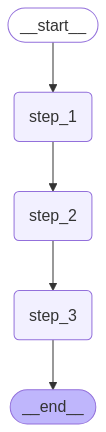

In [4]:
from langgraph.graph import START, END

graph_builder = StateGraph(State)

graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")
graph_builder.add_edge("step_3", END)

graph = graph_builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"value_1": "c"})


{'value_1': 'Hello b', 'value_2': 10}

# B. Nodos paralelos

In [11]:
import operator
from typing import Annotated, Any
from typing_extensions import Annotated
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list[Any], operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


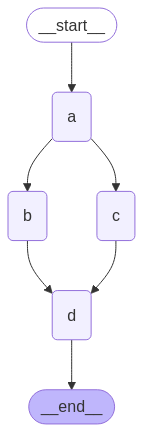

In [8]:
builder = StateGraph(State)

builder.add_node("a", a)
builder.add_node("b", b)
builder.add_node("c", c)
builder.add_node("d", d)

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("c", "d")
builder.add_edge("b", "d")

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"aggregate": []})


Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

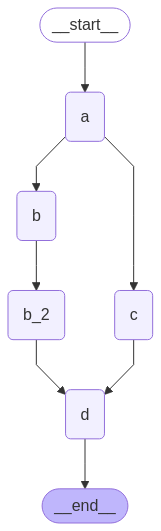

In [14]:
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
builder.add_edge(["b_2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"aggregate": []})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

# C. Conditional branches

In [16]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [17]:
class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}

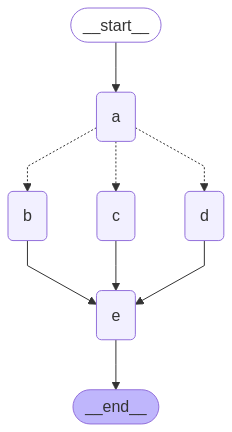

In [22]:
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")

def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]

intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")
builder.add_edge("e", END)
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [24]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [25]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

# D. Basic Loops

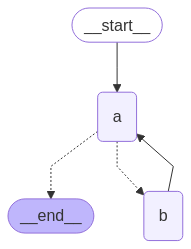

In [37]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
graph.invoke({"aggregate": []})


Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

In [39]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


# E. Loops with branches

In [45]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()

In [55]:
#from IPython.display import Image, display
#display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
result = graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node D sees ['A', 'B']
Node C sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


In [48]:
from langgraph.errors import GraphRecursionError

try:
    result = graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Recursion Error
